#Codalab Emocontext Language Competition.ipynb

We train a model for the [Codalab Emocontext Competition](https://competitions.codalab.org/competitions/19790) that achieves an F1 score of 0.65
on the validation set (compared to a 0.7 score which won the competition). 

In [ ]:
!pip install tensorflow==2.0 -q
!pip install tensorflow-gpu==2.0 -q
!pip install transformers -q

     |████████████████████████████████| 86.3MB 26.8MB/s 
     |████████████████████████████████| 450kB 44.2MB/s 
     |████████████████████████████████| 3.8MB 54.0MB/s 
     |████████████████████████████████| 380.8MB 42kB/s 
     |████████████████████████████████| 317kB 2.8MB/s 
     |████████████████████████████████| 860kB 44.8MB/s 
     |████████████████████████████████| 645kB 43.6MB/s 
     |████████████████████████████████| 1.0MB 40.8MB/s 


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random
from google.colab import drive 
from sklearn.model_selection import train_test_split

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#1. Download the Data

In [ ]:
#Download the data
#Replace these lines with paths to the data for the competition which can be found here: https://competitions.codalab.org/competitions/19790
DRIVE_FOLDER = '/content/drive/My Drive/Emocontext/'

train = pd.read_csv(DRIVE_FOLDER + 'train.txt', sep= "\t") 
test = pd.read_csv(DRIVE_FOLDER + 'devwithoutlabels.txt', sep= "\t") 

print("Loaded training data, shape: ", train.shape)
print(train.head().to_string())
print(" ")

#Check for null values
print(train.isnull().any())
print(test.isnull().any())

#Split into features and dependent variables 
train_X = train.iloc[:, 1:4].values
test_X = test.iloc[:, 1:4].values
train_y = train.iloc[:, 4].values

Loaded training data, shape:  (30160, 5)
   id                  turn1                                              turn2                      turn3   label
0   0  Don't worry  I'm girl                       hmm how do I know if you are            What's ur name?  others
1   1            When did I?                         saw many times i think -_-        No. I never saw you   angry
2   2                     By                                   by Google Chrome             Where you live  others
3   3         U r ridiculous  I might be ridiculous but I am telling the truth.  U little disgusting whore   angry
4   4     Just for time pass                         wt do u do 4 a living then                      Maybe  others
 
id       False
turn1    False
turn2    False
turn3    False
label    False
dtype: bool
id       False
turn1    False
turn2    False
turn3    False
dtype: bool


#2. Retrieve and Save BERT Word Embeddings

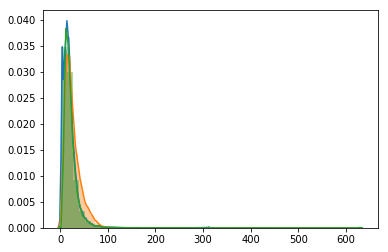

In [ ]:
# First we explore the sentence lengths distribution in the text to help us decide
# how much padding to use
import seaborn as sns
for ix in range(3):  
  sentence_lengths = [len(sentence) for sentence in train_X[:, ix]]
  sns.distplot(sentence_lengths)

In [ ]:
# Embeds all 3 sentences in a datapoint using BERT and then saves to a file
import torch
from transformers import *

tokenizer = tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = TFBertModel.from_pretrained('bert-base-cased')

input_ids = {0:[], 1:[], 2:[]}

#We pad up to 150 because the plots above show that this is more than enough to 
#cover the vast majority of sentences
pad_up_to = 150 

for ix in range(train_X.shape[0]):
  data = train_X[ix]
  for ix, turn in enumerate(data):
    tokens = tokenizer.encode(turn, add_special_tokens=True)
    if len(tokens) < pad_up_to:
      tokens.extend([0 for _ in range(pad_up_to - len(tokens))])
    input_ids[ix].append(tokens)

train_X = np.zeros((train_X.shape[0], pad_up_to, 3), dtype=int)
for ix in range(3):
  train_X[:, :, ix] = input_ids[ix]

all_embeddings = None

for ix in range(3):
  embeddings = None
  data = tf.data.Dataset.from_tensor_slices(input_ids[ix])
  for batch in data.batch(512):
    sentence_embedding = model(batch)[1]
    if embeddings is None:
      embeddings = sentence_embedding
    else:
      embeddings = np.append(embeddings, sentence_embedding, axis=0)
    print(embeddings.shape)
  if all_embeddings is None:
    all_embeddings = embeddings
  else:
    all_embeddings = np.append(all_embeddings, embeddings, axis=1)
  print("ALL embeddings ", all_embeddings.shape)

all_embeddings = np.reshape(all_embeddings, (30160, 768, 3))
np.save("train_bert_embeddings.npy", all_embeddings)

100%|██████████| 213450/213450 [00:00<00:00, 1055520.08B/s]


In [ ]:
# Load the word embeddings (no need to do the previous cell after we've done it once before)
train_X = np.load(DRIVE_FOLDER + "train_bert_embeddings.npy")

#3. Modelling

In [ ]:
from tensorflow.keras import Model, activations
from tensorflow.keras.layers import Dense, Concatenate, GRU, Dropout

gru_hidden_size = 50
dropout_rate = 0.15

class gru_model(Model):

  def __init__(self):
    Model.__init__(self)
    self.gru = GRU(units=gru_hidden_size)
    self.fc_layer1 = Dense(50, activation="relu", kernel_initializer="he_normal")    
    self.fc_layer2 = Dense(4, activation="softmax", kernel_initializer="he_normal")
    self.dropout = Dropout(rate=dropout_rate)
  
  def call(self, x, training=True):
    """Forward pass for the network. Note that it expects input data in the form (batch, seq length, features)"""    
    x = self.dropout(self.gru(x))
    x = self.dropout(self.fc_layer1(x))
    x = self.fc_layer2(x)
    return x

In [ ]:
# We create an F1 callback so we can keep track of the validation F1 score per epoch
from keras.callbacks import Callback
from sklearn.metrics import f1_score
                                          
class F1Evaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
      y_pred = tf.argmax(model(val_X), axis=1).numpy()
      print("\n Val F1 score ", f1_score(val_y, y_pred, average='micro'))
        
f1score = F1Evaluation()
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)                              

Using TensorFlow backend.


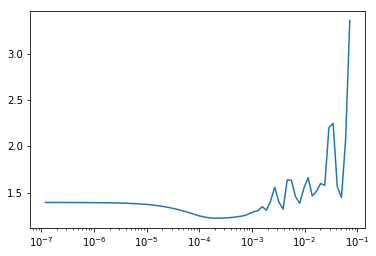

In [ ]:
# We run a method similar to fasti AI's learning rate finder https://docs.fast.ai/callbacks.lr_finder.html
# this method runs iterations at different learning rates and plots the loss. 
# Areas of downward slope then gives us the rough area in which we should choose our learning rate
import matplotlib.pyplot as plt

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

def lr_finder_tf(model, x_batch, y_batch, loss_object):      
    """Based off of the fast AI learning rate finder - https://docs.fast.ai/callbacks.lr_finder.html 
    It works by finding the learning rate at which the gradient of the loss is the most negative"""
    lrs = []
    losses = []

    lr = 0.0000001

    while lr < 0.1:
      lrs.append(lr)
      with tf.GradientTape() as tape:
            y_ = model(x_batch)
            loss_value = loss_object(y_true=y_batch, y_pred=y_)
      grads = tape.gradient(loss_value, model.trainable_variables)
      losses.append(loss_value.numpy())
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))  
      lr *= 1.2 

    running_mean = []
    for ix in range(1, len(losses) - 1):
      mean = np.mean(losses[ix-1:ix+1])
      running_mean.append(mean)

    plt.plot(lrs[1:-1], running_mean)
    plt.xscale('log')
    

model = gru_model()
tr_X, val_X, tr_y, val_y = train_test_split(train_X, train_y, train_size=0.9, random_state=SEED)
tr_X = np.swapaxes(tr_X,1,2)
val_X = np.swapaxes(val_X,1,2)
class_num = {"others": 0, "sad": 1, "angry": 2, "happy": 3}
tr_y = np.vectorize(class_num.get)(tr_y)
val_y = np.vectorize(class_num.get)(val_y)

lr_finder_tf(model, tr_X[:1000, :, :], tr_y[:1000], loss_object)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

batch_size = 32
epochs = 300
learning_rate = 0.0003
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['acc'])
model.fit(tr_X, tr_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(val_X, val_y), callbacks=[f1score, reduce_lr])

Train on 27144 samples, validate on 3016 samples
Epoch 1/300
26912/27144 [============================>.] - ETA: 0s - loss: 1.6533 - acc: 0.4026
 Val F1 score  0.48574270557029176
27144/27144 [==============================] - 7s 268us/sample - loss: 1.6504 - acc: 0.4031 - val_loss: 1.2463 - val_acc: 0.4857
Epoch 2/300
27008/27144 [============================>.] - ETA: 0s - loss: 1.2632 - acc: 0.4877
 Val F1 score  0.48574270557029176
27144/27144 [==============================] - 5s 182us/sample - loss: 1.2630 - acc: 0.4878 - val_loss: 1.2424 - val_acc: 0.4857
Epoch 3/300
27136/27144 [============================>.] - ETA: 0s - loss: 1.2430 - acc: 0.4958
 Val F1 score  0.48574270557029176
27144/27144 [==============================] - 5s 185us/sample - loss: 1.2431 - acc: 0.4957 - val_loss: 1.2314 - val_acc: 0.4857
Epoch 4/300
26944/27144 [============================>.] - ETA: 0s - loss: 1.2302 - acc: 0.4974
 Val F1 score  0.4877320954907162
27144/27144 [============================